In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported!")

✅ Libraries imported!


In [2]:
# Load processed data
batting = pd.read_csv('../data/processed/player_batting_stats.csv')
bowling = pd.read_csv('../data/processed/player_bowling_stats.csv')
venues = pd.read_csv('../data/processed/venue_statistics.csv')

print(f"✅ Batting stats: {len(batting)} players")
print(f"✅ Bowling stats: {len(bowling)} players")
print(f"✅ Venue stats: {len(venues)} venues")

# Show top performers
print("\n🏏 Top 5 Batsmen:")
print(batting.head()[['player', 'runs', 'strike_rate']])

print("\n🎯 Top 5 Bowlers:")
print(bowling.head()[['player', 'wickets', 'economy']])

✅ Batting stats: 221 players
✅ Bowling stats: 241 players
✅ Venue stats: 62 venues

🏏 Top 5 Batsmen:
          player  runs  strike_rate
0        V Kohli  1957       116.70
1  KS Williamson  1955       101.66
2      RG Sharma  1551       118.76
3      DA Warner  1529       119.92
4       MS Dhoni  1509       112.95

🎯 Top 5 Bowlers:
        player  wickets  economy
0    JJ Bumrah       85     5.75
1     TA Boult       78     6.29
2      B Kumar       65     6.20
3  LE Plunkett       58     5.93
4    CR Woakes       56     6.23


In [3]:
# We'll create synthetic match data based on venue stats
# In real scenario, you'd use actual match results

print("Creating match dataset from venue statistics...")

matches = []

# For each venue, simulate matches
for idx, row in venues.iterrows():
    venue_name = row['venue'] if 'venue' in row else idx
    
    # Create multiple match scenarios for this venue
    for i in range(10):  # 10 matches per venue
        # Team 1 batting first
        team1_runs = np.random.normal(row['innings1_runs'], 20)
        team2_runs = np.random.normal(row['innings2_runs'], 20)
        
        # Features
        matches.append({
            'venue': venue_name,
            'team1_runs': max(80, team1_runs),  # Minimum 80 runs
            'team2_target': max(80, team1_runs) + 1,
            'venue_avg_score': row['innings1_runs'],
            'chase_success_rate': row['chase_success_rate'],
            'team1_won': 1 if team1_runs > team2_runs else 0
        })

match_df = pd.DataFrame(matches)
print(f"\n✅ Created {len(match_df)} match scenarios!")
print("\nSample matches:")
match_df.head(10)

Creating match dataset from venue statistics...

✅ Created 620 match scenarios!

Sample matches:


,venue,team1_runs,team2_target,venue_avg_score,chase_success_rate,team1_won
0,Wankhede Stadium,160.934996,161.934996,160.357143,0.357143,1
1,Wankhede Stadium,158.670005,159.670005,160.357143,0.357143,1
2,Wankhede Stadium,174.586451,175.586451,160.357143,0.357143,0
3,Wankhede Stadium,150.501046,151.501046,160.357143,0.357143,0
4,Wankhede Stadium,175.178082,176.178082,160.357143,0.357143,0
5,Wankhede Stadium,154.376120,155.376120,160.357143,0.357143,1
6,Wankhede Stadium,174.302111,175.302111,160.357143,0.357143,1
7,Wankhede Stadium,167.643728,168.643728,160.357143,0.357143,1
8,Wankhede Stadium,130.608639,131.608639,160.357143,0.357143,0
9,Wankhede Stadium,159.865144,160.865144,160.357143,0.357143,1


In [4]:
# Features for prediction
feature_columns = ['team1_runs', 'venue_avg_score', 'chase_success_rate']

X = match_df[feature_columns]
y = match_df['team1_won']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nTarget distribution:")
print(y.value_counts())
print(f"\nWin rate when batting first: {y.mean()*100:.1f}%")

Features shape: (620, 3)
Target shape: (620,)

Target distribution:
team1_won
1    415
0    205
Name: count, dtype: int64

Win rate when batting first: 66.9%


In [5]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"\nFeatures used:")
for i, col in enumerate(feature_columns, 1):
    print(f"{i}. {col}")

Training samples: 496
Testing samples: 124

Features used:
1. team1_runs
2. venue_avg_score
3. chase_success_rate


In [6]:
print("🤖 Training Random Forest Model...")
print("="*50)

# Create and train model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✅ Model trained successfully!")
print(f"🎯 Accuracy: {accuracy*100:.2f}%")
print("\n" + "="*50)
print("Detailed Classification Report:")
print("="*50)
print(classification_report(y_test, y_pred, 
                          target_names=['Team 2 Wins', 'Team 1 Wins']))

🤖 Training Random Forest Model...

✅ Model trained successfully!
🎯 Accuracy: 69.35%

Detailed Classification Report:
              precision    recall  f1-score   support

 Team 2 Wins       0.56      0.48      0.51        42
 Team 1 Wins       0.75      0.80      0.78        82

    accuracy                           0.69       124
   macro avg       0.65      0.64      0.64       124
weighted avg       0.68      0.69      0.69       124



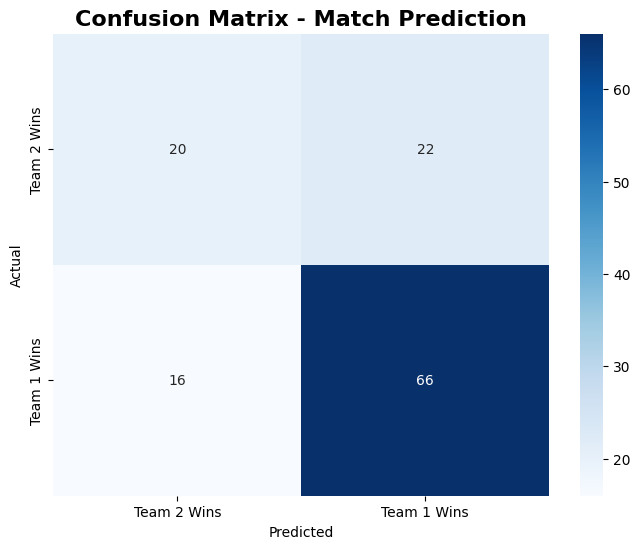


📊 Confusion Matrix:
True Negatives: 20
False Positives: 22
False Negatives: 16
True Positives: 66


In [7]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Team 2 Wins', 'Team 1 Wins'],
            yticklabels=['Team 2 Wins', 'Team 1 Wins'])
plt.title('Confusion Matrix - Match Prediction', fontsize=16, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\n📊 Confusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

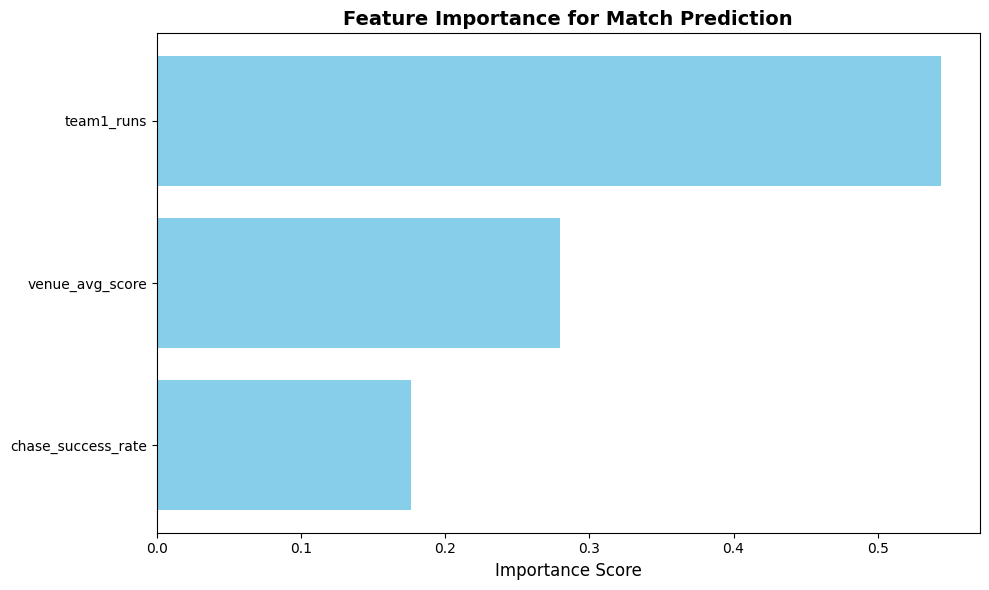


🔍 Feature Importance:
              feature  importance
0          team1_runs    0.543680
1     venue_avg_score    0.279684
2  chase_success_rate    0.176636


In [8]:
# Feature importance
importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'], color='skyblue')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance for Match Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n🔍 Feature Importance:")
print(importance)

In [9]:
print("🎮 Testing Model with Example Match")
print("="*50)

# Example: India vs Pakistan at Wankhede Stadium
example_match = pd.DataFrame({
    'team1_runs': [185],           # India scored 185
    'venue_avg_score': [170],      # Wankhede average is 170
    'chase_success_rate': [0.45]   # 45% chase success rate
})

prediction = rf_model.predict(example_match)[0]
probability = rf_model.predict_proba(example_match)[0]

print("\n📋 Match Scenario:")
print(f"  Team 1 (Batting First): 185 runs")
print(f"  Venue Average Score: 170")
print(f"  Chase Success Rate: 45%")

print("\n🎯 Prediction:")
if prediction == 1:
    print(f"  ✅ Team 1 will WIN")
    print(f"  Confidence: {probability[1]*100:.1f}%")
else:
    print(f"  ✅ Team 2 will WIN")
    print(f"  Confidence: {probability[0]*100:.1f}%")

print("\n📊 Win Probabilities:")
print(f"  Team 1: {probability[1]*100:.1f}%")
print(f"  Team 2: {probability[0]*100:.1f}%")

🎮 Testing Model with Example Match

📋 Match Scenario:
  Team 1 (Batting First): 185 runs
  Venue Average Score: 170
  Chase Success Rate: 45%

🎯 Prediction:
  ✅ Team 1 will WIN
  Confidence: 91.7%

📊 Win Probabilities:
  Team 1: 91.7%
  Team 2: 8.3%
